In [1]:
import os
import re
import glob
from datetime import datetime
import sys
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook as tqdm

from src.datasets import NyseSecuritiesDataset
from src.datasets import NyseStocksDataset
from src.datasets.nyse_stocks import *
import src.nlp_utils as nlp_utils

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

c:\users\thomas\hpi\ma\venv\lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\thomas\hpi\ma\venv\lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)
c:\users\thomas\hpi\ma\venv\lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\thomas\hpi\ma\venv\lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
HOME = ".."
DATA_DIR = "data"
REUTERS = os.path.join(HOME, DATA_DIR, "preprocessed", "news_reuters.csv")
BLOOMBERG = os.path.join(HOME, DATA_DIR, "preprocessed", "news_bloomberg.csv")
NEWS = os.path.join(HOME, DATA_DIR, "preprocessed", "news.csv")
# Columns: 'date', 'filename', 'content'

time: 107 ms


In [3]:
stocks_ds = NyseStocksDataset(file_path='../data/nyse/prices.csv')  # prices-split-adjusted
prices = stocks_ds.get_all_prices()
X_train, y_train, X_test, y_test = stocks_ds.data()


time: 10.8 s


### Inspect train-test-val

In [4]:
train = prices[prices['date'] < TRAIN_VAL_SPLIT][FEATURES]
val = prices[(prices['date'] >= TRAIN_VAL_SPLIT) & (prices['date'] < TRAIN_TEST_SPLIT)][FEATURES]
test = prices[prices['date'] >= TRAIN_TEST_SPLIT][FEATURES]
print(len(train), len(val), len(test), 'out of', len(prices))

477682 247457 126125 out of 851264
time: 223 ms


### Inspect symbols and time spans

In [5]:
securities_ds = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv')
symbols = securities_ds.data()['Ticker symbol'].drop_duplicates()
symbols2 = prices['symbol'].drop_duplicates()
print("Symbols without stock prices:")
print(', '.join(symbols[~symbols.isin(symbols2)]))
assert not any(symbols2.str.find('BRK') != -1)
assert len(symbols2[~symbols2.isin(symbols)]) == 0

Symbols without stock prices:
BRK.B, BF.B, MS, UA
time: 241 ms


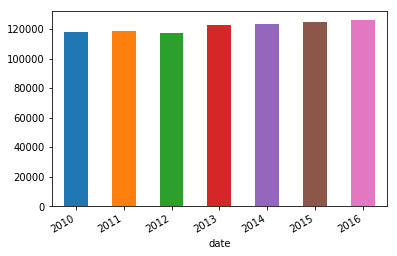

time: 397 ms


In [6]:
ax = prices.date.groupby(prices.date.dt.year).count().plot(kind="bar")
ax.get_figure().autofmt_xdate()

In [95]:
for sym in tqdm(symbols2):
    stocks_prices = prices[prices['symbol'] == sym]
    # assert not any(stocks_prices['date'] >= stocks_prices.shift(-1)['date']), 'Prices are not sorted by date'
    if stocks_prices['date'].min() != START_DATE:
        print(f'{sym}: started at {stocks_prices["date"].min()}')
    if stocks_prices['date'].max() != END_DATE:
        print(f'{sym}: ended at {stocks_prices["date"].max()}')

WLTW: started at 2016-01-14 00:00:00
CHTR: started at 2010-01-05 00:00:00
LYB: started at 2010-04-28 00:00:00
GM: started at 2010-11-18 00:00:00
ABBV: started at 2013-01-02 00:00:00
DLPH: started at 2013-01-02 00:00:00
FB: started at 2013-01-02 00:00:00
FBHS: started at 2013-01-02 00:00:00
HCA: started at 2013-01-02 00:00:00
KMI: started at 2013-01-02 00:00:00
KORS: started at 2013-01-02 00:00:00
MPC: started at 2013-01-02 00:00:00
NLSN: started at 2013-01-02 00:00:00
PSX: started at 2013-01-02 00:00:00
TDG: started at 2013-01-02 00:00:00
TRIP: started at 2013-01-02 00:00:00
XYL: started at 2013-01-02 00:00:00
ZTS: started at 2013-02-01 00:00:00
COTY: started at 2013-06-13 00:00:00
MNK: started at 2013-06-17 00:00:00
NWS: started at 2013-06-19 00:00:00
NWSA: started at 2013-06-19 00:00:00
EVHC: started at 2013-08-14 00:00:00
ALLE: started at 2013-11-18 00:00:00
CFG: started at 2015-01-02 00:00:00
NAVI: started at 2015-01-02 00:00:00
QRVO: started at 2015-01-02 00:00:00
SYF: started at 

### Visualization label distribution

In [7]:
# Source: http://www.gardening.cornell.edu/homegardening/scene638f.html
primary = '#037d95'  # blue green
secondary = '#ffa823'  # orange yellow
ternary = '#c8116b'  # red violet

time: 115 ms


In [10]:
epsilon = 0.01
def get_label(rel_dist):
        return -1 if rel_dist < -epsilon else 1 \
            if rel_dist > epsilon else 0

y = stocks_ds.prices[['open', 'close']].copy()
y['rel_dist'] = 1 - (y['close'] / y['open'])
y['label'] = y['rel_dist'].apply(get_label)

time: 878 ms


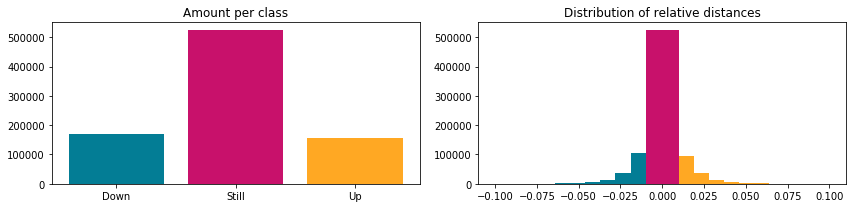

time: 1.07 s


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes = axes.flat

labels_down = y[y['label'] == -1]['rel_dist']
labels_still = y[y['label'] == 0]['rel_dist']
labels_ups = y[y['label'] == 1]['rel_dist']

axes[1].hist(labels_down, range=(-0.1, -epsilon), color=primary)
axes[1].hist(labels_still, range=(-epsilon, epsilon), bins=1, color=ternary)
axes[1].hist(labels_ups, range=(epsilon, 0.1), color=secondary)
axes[1].set_title('Distribution of relative distances')

ind = np.arange(-1, 2)
axes[0].bar(ind, [len(labels_down), len(labels_still), len(labels_ups)],
            color=[primary, ternary, secondary])
axes[0].set_xticks(ind)
axes[0].set_xticklabels(['Down', 'Still', 'Up'])
axes[0].set_title('Amount per class')

fig.tight_layout()
# fig.savefig('./plots/labels_distribution_e01.png')